# SET UP

### IMPORT LIBRARIES

In [1]:
import itertools
import json
import numpy as np
from numpy.linalg import eig
import scipy as sp
import scipy.linalg as la
import networkx as nx
from netgraph import InteractiveGraph, Graph
import quantecon as qe
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import geopandas as gpd
from tqdm import tqdm
from itertools import product
import csv
import argparse
import ast
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
import pandas as pd
import numpy as np

import re


/var/folders/b2/dxx_j33x7rz80jfgfjr_tj2c0000gn/T/ipykernel_6136/228905389.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### DEFINE GLOBAL VARIABLE

In [10]:
def getboundaryofamperfromregion(data):
    amperboundaries = {}
    for i in data.index:
        geom = data.at[i, "geometry"]
        pv_name = data.at[i, 'pv_tn']
        re_name = data.at[i, "re_royin"]
        ap_name = data.at[i, 'ap_tn'] if 'ap_tn' in data else ""

        if geom.geom_type == 'Polygon':
            # print("This geometry is a Polygon")
            coordinates_list = list(geom.exterior.coords)
            coordinates_list = [list(coordinate) for coordinate in coordinates_list]

        elif geom.geom_type == 'MultiPolygon':
            polygon_list = list(geom.geoms)  
            coordinates_list = []
            for polygon in polygon_list:
                polygon_coordinates_list = list(polygon.exterior.coords)
                coordinates_list += [list(coordinate) for coordinate in polygon_coordinates_list]

        amperkey = (ap_name, pv_name)
        centroid = geom.centroid
        amperboundaries[amperkey] = {'cor': coordinates_list, 'centroid':centroid}

    return amperboundaries

with open('data/allprovinces.txt', 'r', encoding='utf-8') as file:
    allprovinces = []
    for line in file:
        # strip() removes any leading and trailing whitespace, including the newline character
        allprovinces.append(line.strip())

central = gpd.read_file('./data/query-2.geojson')
east = gpd.read_file('./data/query-3.geojson')
north = gpd.read_file('./data/query-4.geojson')
south = gpd.read_file('./data/query-5.geojson')
northeast = gpd.read_file('./data/query-6.geojson')
west = gpd.read_file('./data/query-7.geojson')

geojsonlists = [central, east, north, south, northeast, west]

central_amperboundaries = getboundaryofamperfromregion(central)
east_amperboundaries = getboundaryofamperfromregion(east)
north_amperboundaries = getboundaryofamperfromregion(north)
south_amperboundaries = getboundaryofamperfromregion(south)
northeast_amperboundaries = getboundaryofamperfromregion(northeast)
west_amperboundaries = getboundaryofamperfromregion(west)

all_amperboundaries = {**central_amperboundaries, **east_amperboundaries, **north_amperboundaries, **south_amperboundaries, **northeast_amperboundaries, **west_amperboundaries}
allampers = list(all_amperboundaries.keys())

In [13]:
df = pd.DataFrame(allampers, columns=['Amper', 'Province'])
df.to_csv('data/allampers.csv', index=False, encoding='utf-8-sig')

In [2]:
def getboundaryofamperfromregion(data):
    amperboundaries = {}
    for i in data.index:
        geom = data.at[i, "geometry"]
        pv_name = data.at[i, 'pv_tn']
        re_name = data.at[i, "re_royin"]
        ap_name = data.at[i, 'ap_tn'] if 'ap_tn' in data else ""

        if geom.geom_type == 'Polygon':
            # print("This geometry is a Polygon")
            coordinates_list = list(geom.exterior.coords)
            coordinates_list = [list(coordinate) for coordinate in coordinates_list]

        elif geom.geom_type == 'MultiPolygon':
            polygon_list = list(geom.geoms)  
            coordinates_list = []
            for polygon in polygon_list:
                polygon_coordinates_list = list(polygon.exterior.coords)
                coordinates_list += [list(coordinate) for coordinate in polygon_coordinates_list]

        amperkey = (ap_name, pv_name)
        centroid = geom.centroid
        amperboundaries[amperkey] = {'cor': coordinates_list, 'centroid':centroid}

    return amperboundaries

with open('data/allprovinces.txt', 'r', encoding='utf-8') as file:
    allprovinces = []
    for line in file:
        # strip() removes any leading and trailing whitespace, including the newline character
        allprovinces.append(line.strip())

central = gpd.read_file('./data/query-2.geojson')
east = gpd.read_file('./data/query-3.geojson')
north = gpd.read_file('./data/query-4.geojson')
south = gpd.read_file('./data/query-5.geojson')
northeast = gpd.read_file('./data/query-6.geojson')
west = gpd.read_file('./data/query-7.geojson')

geojsonlists = [central, east, north, south, northeast, west]

central_amperboundaries = getboundaryofamperfromregion(central)
east_amperboundaries = getboundaryofamperfromregion(east)
north_amperboundaries = getboundaryofamperfromregion(north)
south_amperboundaries = getboundaryofamperfromregion(south)
northeast_amperboundaries = getboundaryofamperfromregion(northeast)
west_amperboundaries = getboundaryofamperfromregion(west)

all_amperboundaries = {**central_amperboundaries, **east_amperboundaries, **north_amperboundaries, **south_amperboundaries, **northeast_amperboundaries, **west_amperboundaries}
allampers = list(all_amperboundaries.keys())

def checktwoampernexttoeachother(amper1, amper2, distance_threshold=0.05):
    centroid1 = all_amperboundaries[amper1]['centroid']
    centroid2 = all_amperboundaries[amper2]['centroid']

    centroid_distance = np.linalg.norm(np.array([centroid1.x, centroid1.y]) - np.array([centroid2.x, centroid2.y]))
    if centroid_distance < 2: 
        for cor1 in all_amperboundaries[amper1]['cor']:
            for cor2 in all_amperboundaries[amper2]['cor']:
                distance = np.linalg.norm(np.array(cor1) - np.array(cor2))
                if distance < distance_threshold:
                    return True
    
    return False

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

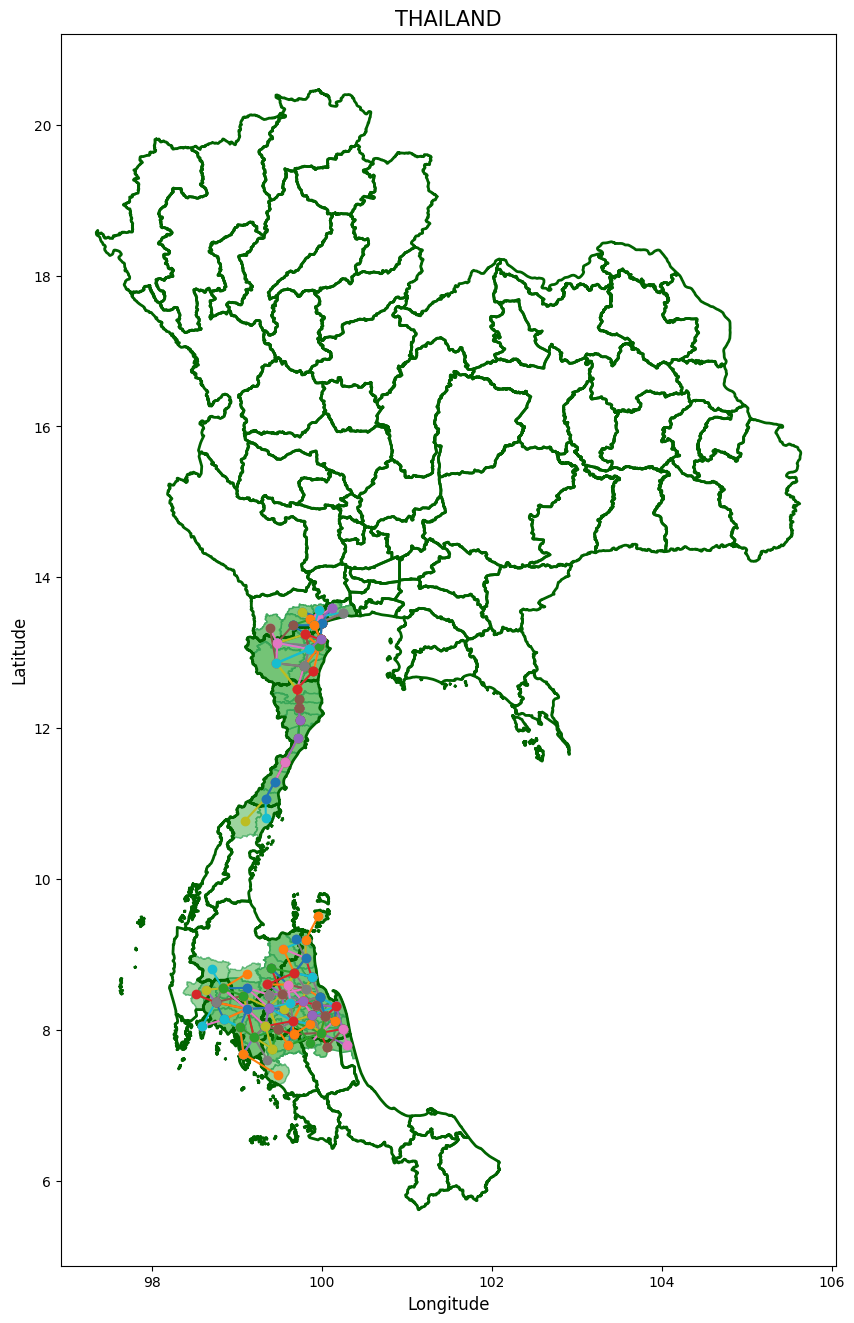

In [5]:
central = gpd.read_file('./data/query-2.geojson')
east = gpd.read_file('./data/query-3.geojson')
north = gpd.read_file('./data/query-4.geojson')
south = gpd.read_file('./data/query-5.geojson')
northeast = gpd.read_file('./data/query-6.geojson')
west = gpd.read_file('./data/query-7.geojson')

geojsonlists = [central, east, north, south, northeast, west]

fillopa = 0.7  
opa = 0.5
color_fill = '#74c476'  
border_color = '#31a354'  
highlight_color = '#de2d26' 
weight_line = 0.5  

def plotamperboundary(ax, ampername, provincename):
    for geojson in geojsonlists:
        for i in geojson.index:
            geom = geojson.at[i, "geometry"]
            pv_name = geojson.at[i, 'pv_tn']
            re_name = geojson.at[i, "re_royin"]
            ap_name = geojson.at[i, 'ap_tn'] if 'ap_tn' in geojson else ""

            centroid = geom.centroid
            ax.plot(centroid.x, centroid.y, 'o', color='blue', alpha=0.5, markersize=1)

            if ampername==ap_name and provincename==pv_name:
                if geom.geom_type == 'Polygon':
                    x, y = geom.exterior.xy
                    centroid = geom.centroid
                    ax.fill(x, y, color=color_fill, alpha=fillopa, edgecolor=border_color, linewidth=1)
                elif geom.geom_type == 'MultiPolygon':
                    for polygon in geom.geoms: 
                        x, y = polygon.exterior.xy
                        ax.fill(x, y, color=color_fill, alpha=fillopa, edgecolor=border_color, linewidth=1)

def plot2ampersboundaryandconnectedline(ax, ampername1, provincename1, ampername2, provincename2):
    centroids = []
    for geojson in geojsonlists:
        for i in geojson.index:
            geom = geojson.at[i, "geometry"]
            pv_name = geojson.at[i, 'pv_tn']
            re_name = geojson.at[i, "re_royin"]
            ap_name = geojson.at[i, 'ap_tn'] if 'ap_tn' in geojson else ""

            if (ampername1==ap_name and provincename1==pv_name) or (ampername2==ap_name and provincename2==pv_name) :
                centroids.append(geom.centroid)
                if geom.geom_type == 'Polygon':
                    x, y = geom.exterior.xy
                    ax.fill(x, y, color=color_fill, alpha=fillopa, edgecolor=border_color, linewidth=1)
                elif geom.geom_type == 'MultiPolygon':
                    for polygon in geom.geoms: 
                        x, y = polygon.exterior.xy
                        ax.fill(x, y, color=color_fill, alpha=fillopa, edgecolor=border_color, linewidth=1)
    
    x_values = []
    y_values = []
    for centroid in centroids:
        ax.plot(centroid.x, centroid.y, 'o', color='blue', alpha=0.5, markersize=1)
        x_values.append(centroid.x)
        y_values.append(centroid.y)

    ax.plot(x_values, y_values, marker='o', linestyle='-')


### MAIN PLOT ###
fig, ax = plt.subplots(figsize=(10, 16))

### PROVINCE BOUNDARY ###
provinces = gpd.read_file('./data/query.geojson')
for i in range(len(provinces['pv_tn'])):
    geom = provinces["geometry"][i]
    pv_name = provinces['pv_tn'][i]
    if geom.geom_type == 'Polygon':
        x, y = geom.exterior.xy
        ax.plot(x, y, color='darkgreen', linewidth=2)

    elif geom.geom_type == 'MultiPolygon':
        for polygon in geom.geoms: 
            x, y = polygon.exterior.xy
            ax.plot(x, y, color='darkgreen', linewidth=2)


### DISTRICT BOUNDARY ###
df_60to65 = pd.read_csv("gen_data/60-65.csv")
# df_60to65 = df_60to65[0:5]
N = len(df_60to65)
for i in range(N):
    print(i)
    amper1_tuple = ast.literal_eval(df_60to65.iloc[i]["Amper1"])
    amper2_tuple = ast.literal_eval(df_60to65.iloc[i]["Amper2"])
    
    ampername1 = amper1_tuple[0]
    provincename1 = amper1_tuple[1]
    ampername2 = amper2_tuple[0]
    provincename2 = amper2_tuple[1]

    # plotamperboundary(ax, ampername1, provincename1)
    plot2ampersboundaryandconnectedline(ax, ampername1, provincename1, ampername2, provincename2)

ax.set_title('THAILAND', fontsize=15)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12) 
plt.show()                        

In [18]:
import json
import pandas as pd

with open('data/provinces.json', 'r') as file:
    provinces = json.load(file)

df = pd.DataFrame(list(provinces.items()), columns=['Thai', 'English'])

df.to_csv('data/provincesTH2EN.csv', index=False, encoding='utf-8-sig')

In [1]:
import pandas as pd

allampers = pd.read_csv("data/allampers.csv")
allampers.head()

/var/folders/b2/dxx_j33x7rz80jfgfjr_tj2c0000gn/T/ipykernel_10109/589640978.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Amper TH,Amper TH2,Province TH,Province EN,Amper TH3,CODE,Amper EN,ที่ว่าการอำเภอAmper TH Province TH,Lat,Lon
0,เมืองกระบี่,เมืองกระบี่,กระบี่,Krabi,เมืองกระบี่,81010000,Mueang Krabi,ที่ว่าการอำเภอเมืองกระบี่ กระบี่,8.061763,98.918572
1,เขาพนม,เขาพนม,กระบี่,Krabi,เขาพนม,81020000,Khao Phanom,ที่ว่าการอำเภอเขาพนม กระบี่,8.264923,99.049639
2,เกาะลันตา,เกาะลันตา,กระบี่,Krabi,เกาะลันตา,81030000,Ko Lanta,ที่ว่าการอำเภอเกาะลันตา กระบี่,7.655484,99.041715
3,คลองท่อม,คลองท่อม,กระบี่,Krabi,คลองท่อม,81040000,Khlong Thom,ที่ว่าการอำเภอคลองท่อม กระบี่,7.954236,99.144895
4,อ่าวลึก,อ่าวลึก,กระบี่,Krabi,อ่าวลึก,81050000,Ao Luek,ที่ว่าการอำเภออ่าวลึก กระบี่,8.377944,98.722160
